In [1]:
import pandas as pd
from datetime import datetime

def count_time(func):
    def wrapper(*args, **kwargs):
        start = datetime.now()
        func(*args, **kwargs)
        print(f"Czas wczytywania {func.__name__}: {datetime.now() - start} sekund")
        return func(*args, **kwargs)
    return wrapper

def sizeof_fmt(num, suffix="B"):
    for unit in ("", "Ki", "Mi", "Gi", "Ti", "Pi", "Ei", "Zi"):
        if abs(num) < 1024.0:
            return f"{num:3.1f}{unit}{suffix}"
        num /= 1024.0
    return f"{num:.1f}Yi{suffix}"

def describe_size(dataframe: pd.DataFrame):
    output = ''
    tmp = str(sizeof_fmt(sum(dataframe.memory_usage(deep=True))))
    print(tmp)
    output += tmp +'\n'
    for i in dataframe.columns:
        tmp = sizeof_fmt(dataframe[i].memory_usage(deep=True))
        print(i, tmp)
        output += i + ' ' + tmp +'\n'

    return output


In [2]:
import glob
import fastparquet

file_list = glob.glob('/home/ryba/Documents/Code/snek/bigdata/datasets/instagram/private_instagram/*0[0-7].parquet')

df = pd.concat([pd.read_parquet(file, engine='fastparquet') for file in file_list], ignore_index=True)


In [3]:
d1 = describe_size(df)


9.9GiB
sid 70.0MiB
sid_profile 70.0MiB
post_id 525.1MiB
profile_id 70.0MiB
date 595.2MiB
post_type 70.0MiB
description 4.5GiB
likes 70.0MiB
comments 70.0MiB
username 540.4MiB
bio 2.2GiB
following 70.0MiB
followers 70.0MiB
num_posts 70.0MiB
is_business_account 8.8MiB
lang 446.4MiB
category 577.0MiB


In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9178864 entries, 0 to 9178863
Data columns (total 17 columns):
 #   Column               Dtype 
---  ------               ----- 
 0   sid                  int64 
 1   sid_profile          int64 
 2   post_id              object
 3   profile_id           int64 
 4   date                 object
 5   post_type            int64 
 6   description          object
 7   likes                int64 
 8   comments             int64 
 9   username             object
 10  bio                  object
 11  following            int64 
 12  followers            int64 
 13  num_posts            int64 
 14  is_business_account  bool  
 15  lang                 object
 16  category             object
dtypes: bool(1), int64(9), object(7)
memory usage: 1.1+ GB


In [5]:
import numpy as np
s = np.iinfo(np.uint16).max - 	183730.00000
s


-118195.0

In [6]:
def change_dtypes(df: pd.DataFrame, dtype_map: dict) -> pd.DataFrame:
    for dtype, columns in dtype_map.items():
        if not isinstance(columns, list):
            columns = [columns]

        for column in columns:
            try:
                if dtype == 'timestamp':
                    df[column] = pd.to_datetime(df[column]).astype('int64') // 10**9
                    df[column] = df[column].astype('uint32')
                elif isinstance(dtype, list):
                    success = False
                    for dt in dtype:
                        try:
                            df[column] = df[column].astype(dt)
                            success = True
                            break
                        except Exception as e:
                            pass  # Try the next dtype
                    if not success:
                        print(f"Error converting column '{column}' to any of {dtype}")
                else:
                    # Single dtype, attempt conversion
                    df[column] = df[column].astype(dtype)
            except Exception as e:
                print(f"Error converting column '{column}' to '{dtype}': {e}")
    return df

df2 = change_dtypes(df, {
    'category': ['post_type', 'lang', 'username','category', 'bio', 'profile_id'],
    'timestamp': 'date',
    'uint32': ['sid', 'likes', 'comments', 'following', 'followers', 'num_posts'],
    'int32': 'sid_profile',
})


In [7]:
display(df2.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9178864 entries, 0 to 9178863
Data columns (total 17 columns):
 #   Column               Dtype   
---  ------               -----   
 0   sid                  uint32  
 1   sid_profile          int32   
 2   post_id              object  
 3   profile_id           category
 4   date                 uint32  
 5   post_type            category
 6   description          object  
 7   likes                uint32  
 8   comments             uint32  
 9   username             category
 10  bio                  category
 11  following            uint32  
 12  followers            uint32  
 13  num_posts            uint32  
 14  is_business_account  bool    
 15  lang                 category
 16  category             category
dtypes: bool(1), category(6), int32(1), object(2), uint32(7)
memory usage: 659.6+ MB


None

In [8]:
d2 = describe_size(df2)
print(d2)



5.7GiB
sid 35.0MiB
sid_profile 35.0MiB
post_id 525.1MiB
profile_id 74.0MiB
date 35.0MiB
post_type 8.8MiB
description 4.5GiB
likes 35.0MiB
comments 35.0MiB
username 118.9MiB
bio 252.6MiB
following 35.0MiB
followers 35.0MiB
num_posts 35.0MiB
is_business_account 8.8MiB
lang 8.8MiB
category 8.8MiB
5.7GiB
sid 35.0MiB
sid_profile 35.0MiB
post_id 525.1MiB
profile_id 74.0MiB
date 35.0MiB
post_type 8.8MiB
description 4.5GiB
likes 35.0MiB
comments 35.0MiB
username 118.9MiB
bio 252.6MiB
following 35.0MiB
followers 35.0MiB
num_posts 35.0MiB
is_business_account 8.8MiB
lang 8.8MiB
category 8.8MiB



<Figure size 1200x600 with 0 Axes>

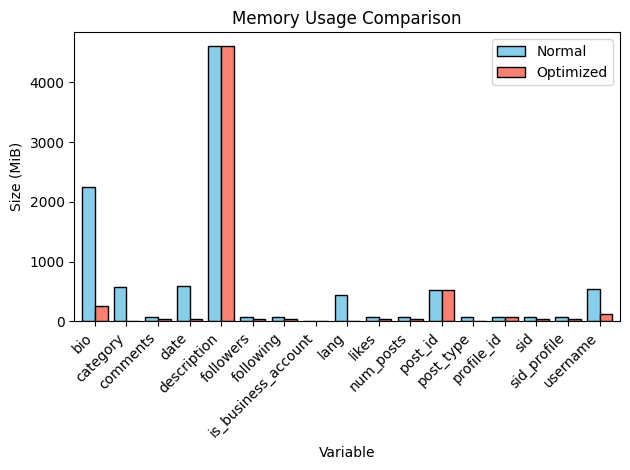

In [9]:
import re
import pandas as pd
import matplotlib.pyplot as plt

def parse_data(data_str):
    """Parse multiline string data to a DataFrame with sizes in MiB."""
    lines = data_str.strip().splitlines()[1:]  # Discard the first line
    variables, sizes = [], []
    
    for line in lines:
        match = re.match(r"(\S+)\s([\d.]+)([GM]iB)", line)
        if match:
            var_name = match.group(1)
            size = float(match.group(2))
            unit = match.group(3)
            if unit == "GiB":
                size *= 1024  # Convert GiB to MiB
            variables.append(var_name)
            sizes.append(size)
    
    return pd.DataFrame({"Variable": variables, "Size (MiB)": sizes}).set_index("Variable")

def plot_comparison(data_str1, data_str2, n1, n2):
    """Load two data strings, convert to DataFrames, and plot comparison bar chart."""
    # Parse both data strings
    df1 = parse_data(data_str1)
    df2 = parse_data(data_str2)

    # Align data by joining on index (Variable name), filling missing values with 0
    df = df1.join(df2, lsuffix='_df1', rsuffix='_df2', how='outer').fillna(0)

    # Plotting
    plt.figure(figsize=(12, 6))
    df.plot(kind="bar", width=0.8, color=["skyblue", "salmon"], edgecolor="black")
    plt.xlabel("Variable")
    plt.ylabel("Size (MiB)")
    plt.title("Memory Usage Comparison")
    plt.xticks(rotation=45, ha='right')
    plt.legend([n1, n2], loc="upper right")
    plt.tight_layout()
    plt.show()

plot_comparison(d1, d2, 'Normal', 'Optimized')


In [10]:
@count_time
def groupBy(df, col):
    return df.groupby(col)

x =  groupBy(df, 'category').agg({'likes':['sum','mean'], })
del x

x =  groupBy(df2, 'category').agg({'likes':['sum','mean']})
del x

del df


/tmp/ipykernel_78352/2845101682.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby(col)


Czas wczytywania groupBy: 0:00:00.000242 sekund
Czas wczytywania groupBy: 0:00:00.000123 sekund


In [11]:
import os
@count_time
def write_parquet():
    df2.to_parquet('lab1/df.parquet', engine='fastparquet')

@count_time
def read_parquet_1():
    df3 = pd.read_parquet('lab1/df.parquet', engine='fastparquet')
    return df3

write_parquet()

x = read_parquet_1()
del x


Czas wczytywania write_parquet: 0:00:12.082569 sekund
Czas wczytywania read_parquet_1: 0:00:10.484553 sekund


In [12]:
@count_time
def write_csv_1():
    df2.to_csv('lab1/csv_simple.csv', header=True, index=False)


@count_time
def read_csv_1():
    df3 = pd.read_csv('lab1/csv_simple.csv')
    return df3

write_csv_1()
del df2

x = read_csv_1()
del x


Czas wczytywania write_csv_1: 0:03:06.146101 sekund
Czas wczytywania read_csv_1: 0:00:32.912591 sekund


In [13]:
@count_time
def read_csv_2():
    df3 = pd.read_csv('lab1/csv_simple.csv', chunksize=1_000_000)
    return df3


x = read_csv_2()
del x


Czas wczytywania read_csv_2: 0:00:00.006334 sekund


In [ ]:
# Słaba optymalizacja pamięciowa
os.system('rm -rf ./lab1/csv_chunks')
os.system('mkdir ./lab1/csv_chunks')
print(os.system('.venv/bin/python lab1.py'))


Czas wczytywania load_files: 0:00:43.592375 sekund
0


In [ ]:
os.system('rm -rf ./lab1/csv_chunks')
os.system('mkdir ./lab1/csv_chunks')
# linuxowe voodoo
print(os.system('pkexec ionice -c1 -n0 nice -n -10 /home/ryba/Documents/Code/snek/bigdata/.venv/bin/python /home/ryba/Documents/Code/snek/bigdata/lab1.py'))


Czas wczytywania load_files: 0:00:38.568001 sekund
0


In [15]:

print(os.system('tree -h ./lab1'))


0
[  68]  ./lab1
├── [ 644]  csv_chunks
│   ├── [158M]  csv_simple_10.csv
│   ├── [172M]  csv_simple_11.csv
│   ├── [168M]  csv_simple_12.csv
│   ├── [164M]  csv_simple_13.csv
│   ├── [166M]  csv_simple_14.csv
│   ├── [163M]  csv_simple_15.csv
│   ├── [160M]  csv_simple_16.csv
│   ├── [171M]  csv_simple_17.csv
│   ├── [171M]  csv_simple_18.csv
│   ├── [ 58M]  csv_simple_19.csv
│   ├── [197M]  csv_simple_1.csv
│   ├── [197M]  csv_simple_2.csv
│   ├── [197M]  csv_simple_3.csv
│   ├── [199M]  csv_simple_4.csv
│   ├── [191M]  csv_simple_5.csv
│   ├── [180M]  csv_simple_6.csv
│   ├── [156M]  csv_simple_7.csv
│   ├── [193M]  csv_simple_8.csv
│   ├── [195M]  csv_simple_9.csv
│   └── [ 662]  manifest
├── [3.2G]  csv_simple.csv
└── [1.2G]  df.parquet

2 directories, 22 files
